In [1]:
import numpy as np
from ultralytics import YOLO
from PIL import Image
import matplotlib.pyplot as plt

# Load the YOLOv8 model
model = YOLO("runs/barrel/yolov8n_custom/weights/best.pt")


image 1/1 c:\Users\dk\Desktop\barrel_detection\data\val\PXL_20240705_130706817.jpg: 640x480 1 barrel, 1 tank, 95.6ms
Speed: 5.5ms preprocess, 95.6ms inference, 173.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs\pose\predict3


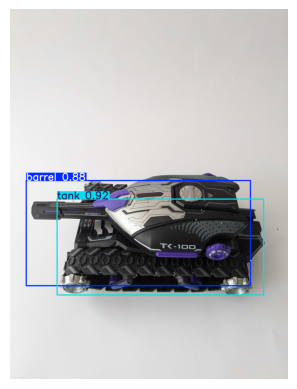

In [2]:
# Define the path or URL to the image
image_path = "data/val/PXL_20240705_130706817.jpg" # should be test image, not valid image (used for testing as there is no test image)

# Run inference on the image
results = model.predict(image_path, save=True, imgsz=640, conf=0.87) # might need to change confidence threshold

# Get the first result (assuming only one image was passed)
result = results[0]

# Visualize the detections on the image
result_image = result.plot()

# Convert the color space from BGR to RGB
rgb_image = result_image[:, :, ::-1]

# Display the image with detections
plt.imshow(rgb_image)
plt.axis('off')  # Hide axis
plt.show()

In [3]:
print(result.keypoints)

ultralytics.engine.results.Keypoints object with attributes:

conf: tensor([[0.7556, 0.7870, 0.5954, 0.6254, 0.6199],
        [0.7842, 0.8239, 0.6955, 0.6107, 0.1671]], device='cuda:0')
data: tensor([[[8.7818e+02, 2.3346e+03, 7.5561e-01],
         [2.3011e+03, 2.3301e+03, 7.8703e-01],
         [2.6183e+03, 2.7416e+03, 5.9539e-01],
         [7.8184e+02, 2.8860e+03, 6.2543e-01],
         [2.9101e+03, 2.4012e+03, 6.1986e-01]],

        [[6.8742e+02, 2.0936e+03, 7.8419e-01],
         [2.0826e+03, 2.1906e+03, 8.2389e-01],
         [2.0239e+03, 2.2959e+03, 6.9552e-01],
         [1.0443e+03, 2.2426e+03, 6.1068e-01],
         [0.0000e+00, 0.0000e+00, 1.6710e-01]]], device='cuda:0')
has_visible: True
orig_shape: (4032, 3024)
shape: torch.Size([2, 5, 3])
xy: tensor([[[ 878.1783, 2334.6001],
         [2301.1167, 2330.0986],
         [2618.3167, 2741.6135],
         [ 781.8389, 2886.0291],
         [2910.0588, 2401.1670]],

        [[ 687.4241, 2093.6123],
         [2082.5608, 2190.6211],
        

In [15]:
# Extract keypoints for the barrel and the tank
keypoints_data = result.keypoints.xy.cpu().numpy()

# Assuming the first row is for the barrel and the second for the tank
barrel_keypoints = keypoints_data[0]
tank_keypoints = keypoints_data[1]

# Define the keypoints for barrel and tank
barrel_points = {
    "muzzle": barrel_keypoints[0],
    "intersection": barrel_keypoints[1]
}

tank_points = {
    "top-right": tank_keypoints[0],
    "bottom-right": tank_keypoints[1]
}

# Function to calculate the angle between two vectors
def calculate_angle(pt1, pt2, pt3, pt4):
    # Vector from pt1 to pt2 (barrel)
    vector1 = np.array(pt2) - np.array(pt1)
    # Vector from pt3 to pt4 (tank)
    vector2 = np.array(pt4) - np.array(pt3)

    # Calculate the angle between two vectors
    unit_vector1 = vector1 / np.linalg.norm(vector1)
    unit_vector2 = vector2 / np.linalg.norm(vector2)
    dot_product = np.dot(unit_vector1, unit_vector2)
    angle = np.arccos(dot_product)

    # Convert from radians to degrees
    angle = np.degrees(angle)
    return angle

# Calculate the rotation angle between the barrel and the tank
angle = calculate_angle(barrel_points["muzzle"], barrel_points["intersection"], tank_points["top-right"], tank_points["bottom-right"])

# Print the end barrel as a vector
print(f"Barrel vector: Muzzle ({barrel_points['muzzle'][0]:.2f}, {barrel_points['muzzle'][1]:.2f}), Intersection of the barrel with the turret ({barrel_points['intersection'][0]:.2f}, {barrel_points['intersection'][1]:.2f})")

# Print the rotation angle
print(f"Estimated Rotation Angle (relatively between barrel and hull sides): {angle:.2f} degrees")

# Assuming barrel_points dictionary contains the points 'muzzle' and 'intersection'
muzzle_x, muzzle_y = barrel_points['muzzle']
intersection_x, intersection_y = barrel_points['intersection']

# Calculate the orientation vector components
orientation_vector_x = muzzle_x - intersection_x
orientation_vector_y = muzzle_y - intersection_y

# Print the orientation vector
print(f"Barrel Orientation vector: ({orientation_vector_x:.2f}, {orientation_vector_y:.2f})")

Barrel vector: Muzzle (878.18, 2334.60), Intersection of the barrel with the turret (2301.12, 2330.10)
Estimated Rotation Angle (relatively between barrel and hull sides): 4.16 degrees
Orientation vector: (-1422.94, 4.50)
